# Define TF version of the layer

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.contrib.keras import layers
from tensorflow.python.layers.core import Dense


class ConcreteDropout(layers.Wrapper):
    """This wrapper allows to learn the dropout probability
        for any given input layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers, not just `Dense`,
    for instance with a `Conv2D` layer:
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$
             (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and
             N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eucledian
            loss.

    # Warning
        You must import the actual layer class from tf layers,
         else this will not work.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = (np.log(init_min) - np.log(1. - init_min))
        self.init_max = (np.log(init_max) - np.log(1. - init_max))

    def build(self, input_shape=None):
        self.input_spec = layers.InputSpec(shape=input_shape)
        if hasattr(self.layer, 'built') and not self.layer.built:
            self.layer.build(input_shape)

        # initialise p
        self.p_logit = self.add_variable(name='p_logit',
                                         shape=None,
                                         initializer=tf.random_uniform(
                                             (1,),
                                             self.init_min,
                                             self.init_max),
                                         dtype=tf.float32,
                                         trainable=True)

        self.p = tf.nn.sigmoid(self.p_logit[0])
        tf.add_to_collection("LAYER_P", self.p)

        # initialise regulariser / prior KL term
        input_dim = int(np.prod(input_shape[1:]))

        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * tf.reduce_sum(tf.square(
            weight)) / (1. - self.p)
        dropout_regularizer = self.p * tf.log(self.p)
        dropout_regularizer += (1. - self.p) * tf.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = tf.reduce_sum(kernel_regularizer + dropout_regularizer)
        # Add the regularisation loss to collection.
        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES,
                             regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = 1e-7
        temp = 0.1

        unif_noise = tf.random_uniform(shape=tf.shape(x))
        drop_prob = (
            tf.log(self.p + eps)
            - tf.log(1. - self.p + eps)
            + tf.log(unif_noise + eps)
            - tf.log(1. - unif_noise + eps)
        )
        drop_prob = tf.nn.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if training:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            self.layer.call(inputs)


def concrete_dropout(inputs, layer,
                     trainable=True,
                     weight_regularizer=1e-6,
                     dropout_regularizer=1e-5,
                     init_min=0.1, init_max=0.1,
                     training=True,
                     name=None,
                     **kwargs):

    cd_layer = ConcreteDropout(layer, weight_regularizer=weight_regularizer,
                               dropout_regularizer=dropout_regularizer,
                               init_min=init_min, init_max=init_max,
                               trainable=trainable,
                               name=name)
    return cd_layer.apply(inputs, training=training)

# Evaluate Concrete Dropout on synthetic data

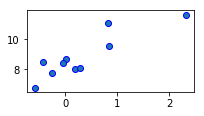

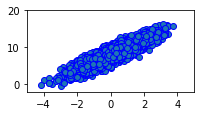

In [2]:
import numpy as np
import sys

Ns = [10, 25, 50, 100, 1000, 10000]
Ns = np.array(Ns)
nb_epochs = [2000, 1000, 500, 200, 20, 2]
nb_val_size = 1000
nb_features = 1024
Q = 1
D = 1
K_test = 20
nb_reps = 3
batch_size = 20
l = 1e-4

def gen_data(N):
    sigma = 1e0  # ground truth
    X = np.random.randn(N, Q)
    w = 2.
    b = 8.
    Y = X.dot(w) + b + sigma * np.random.randn(N, D)
    return X, Y

import pylab
%matplotlib inline

X, Y = gen_data(10)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
pylab.savefig('data_10.pdf', bbox_inches='tight')
pylab.show()

X, Y = gen_data(10000)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
pylab.xlim([-5, 5])
pylab.ylim([-2, 20])
pylab.savefig('data_10000.pdf', bbox_inches='tight')
pylab.show()

# Fit

In [3]:
from tensorflow.python.layers.core import Dense

def fit_model(nb_epoch, X, Y):
    tf.reset_default_graph()
    sess = tf.Session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = tf.placeholder(shape=(None, Q), dtype=tf.float32)
    out = tf.placeholder(shape=(None, Q), dtype=tf.float32)
    x = inp
    for i in range(3):
        x = ConcreteDropout(Dense(nb_features, activation=tf.nn.relu), weight_regularizer=wd,
                            dropout_regularizer=dd, trainable=True)(x, training=True)
        
    mean = ConcreteDropout(Dense(D), weight_regularizer=wd,
                           dropout_regularizer=dd, trainable=True)(x, training=True)
    log_var = ConcreteDropout(Dense(D), weight_regularizer=wd,
                              dropout_regularizer=dd, trainable=True)(x, training=True)
    pred = tf.concat([mean, log_var], -1, name='main_output')
    
    def heteroscedastic_loss(true, pred):
        mean = pred[:, :D]
        log_var = pred[:, D:]
        precision = tf.exp(-log_var)
        reg_losses = tf.reduce_sum(tf.losses.get_regularization_losses())
        return tf.reduce_sum(precision * (true - mean)**2. + log_var + reg_losses, -1)
    
    _loss = heteroscedastic_loss(out, pred)
    opt = tf.train.AdamOptimizer().minimize(_loss)
    assert len(tf.losses.get_regularization_losses()) == 5, print(len(tf.losses.get_regularization_losses()))  # a loss for each Concrete Dropout layer
    
    # init values
    sess.run(tf.global_variables_initializer())
    
    _losses = []
    for epoch in range(nb_epoch):
        old_batch = 0
        for batch in range(int(np.ceil(X.shape[0]/batch_size))):
            batch = (batch + 1)
            _x = X[old_batch: batch_size*batch]
            _y = Y[old_batch: batch_size*batch]
            _, loss = sess.run([opt, _loss], feed_dict={inp: _x, out: _y})
            _losses.append(loss)
            old_batch = batch_size*batch
            
    loss = _losses[-1]
    
    def model_predict(X_val):
        _preds = None
        old_batch = 0
        for batch in range(int(np.ceil(X_val.shape[0]/batch_size))):
            batch = (batch + 1)
            _x = X_val[old_batch: batch_size * batch]
            _pred = sess.run([pred], feed_dict={inp: _x})
            old_batch = batch_size * batch          
            _preds = _pred if _preds is None else np.concatenate([_preds, _pred], axis=1)
        
        return _preds
    
    return sess, model_predict, -0.5 * loss

# Eval

In [4]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, MC_samples):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    assert len(MC_samples.shape) == 3
    assert len(Y_true.shape) == 2
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    mean = MC_samples[:, :, :D]  # K x N x D
    logvar = MC_samples[:, :, D:]
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_true[None])**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi)
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_true)**2.)**0.5
    return pppp, rmse

# Plot

In [5]:
def plot(X_train, Y_train, X_val, Y_val, means):
    indx = np.argsort(X_val[:, 0])
    _, (ax1, ax2, ax3, ax4) = pylab.subplots(1, 4,figsize=(12, 1.5), sharex=True, sharey=True)
    ax1.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax1.set_title('Train set')
    ax2.plot(X_val[indx, 0], np.mean(means, 0)[indx, 0], color='skyblue', lw=3)
    ax2.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax2.set_title('+Predictive mean')
    for mean in means:
        ax3.scatter(X_val[:, 0], mean[:, 0], c='b', alpha=0.2, lw=0)
    ax3.plot(X_val[indx, 0], np.mean(means, 0)[indx, 0], color='skyblue', lw=3)
    ax3.set_title('+MC samples on validation X')
    ax4.scatter(X_val[:, 0], Y_val[:, 0], c='r', alpha=0.2, lw=0)
    ax4.set_title('Validation set')
    pylab.show()

# Run experiment

2000


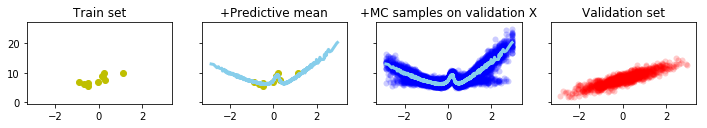

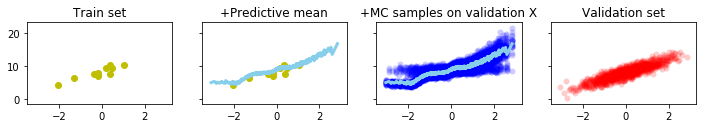

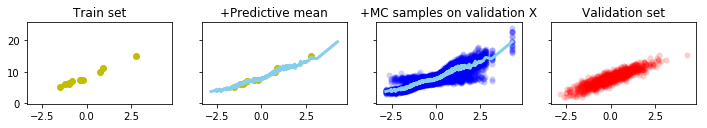

10 2000 - 1.60423201674 0.316877809078 [ 0.07415819  0.40364766  0.40347826  0.40335548  0.40377486]  -  1.02791594029 0.861922493692
1000


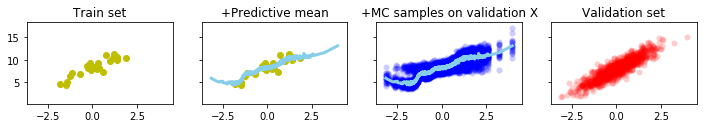

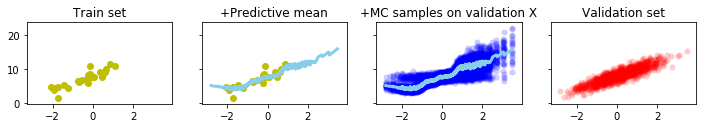

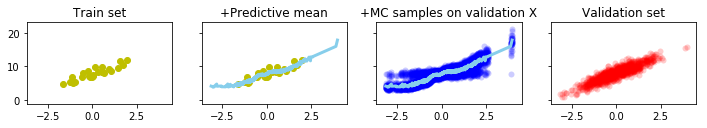

25 1000 - 1.19316615281 0.0164542293493 [ 0.06994522  0.36166361  0.36148462  0.36145067  0.36191145]  -  1.0915614985 0.779587923162
500


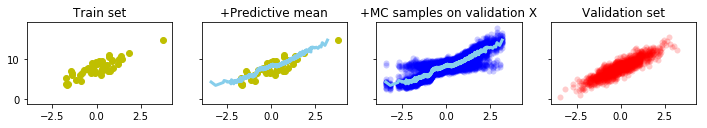

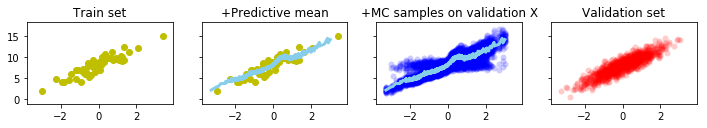

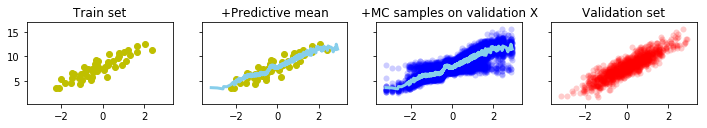

50 500 - 1.11783758262 0.0102436414355 [ 0.07725683  0.3153241   0.31516561  0.31510171  0.31565487]  -  1.25112049427 0.764154501215
200


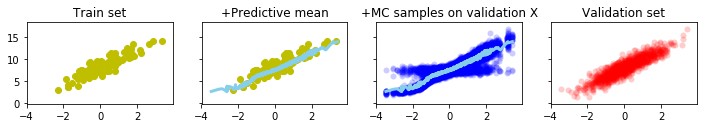

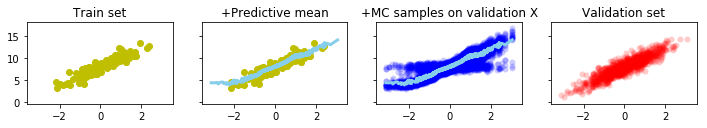

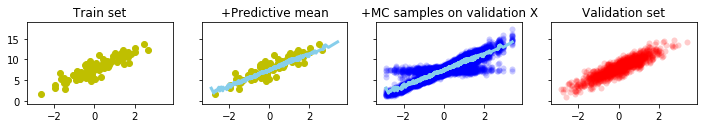

100 200 - 1.10326831095 0.0336444729804 [ 0.07840168  0.23576896  0.23567824  0.2355396   0.23609598]  -  1.27294121181 0.715460839246
20


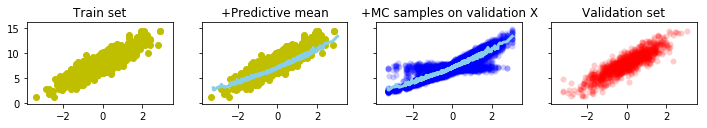

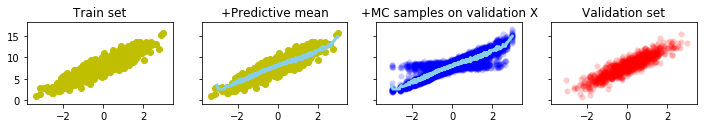

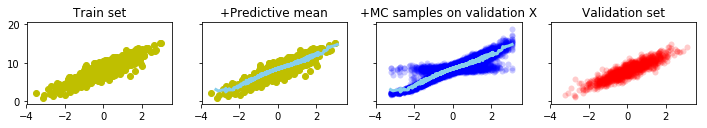

1000 20 - 1.16889844192 0.0936926954501 [ 0.07366523  0.23019637  0.22964412  0.22558789  0.2344135 ]  -  1.38964247551 0.655670295983
2


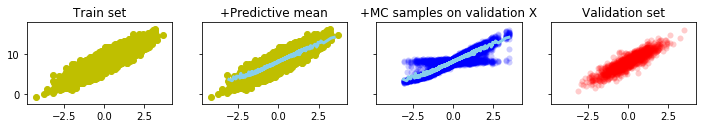

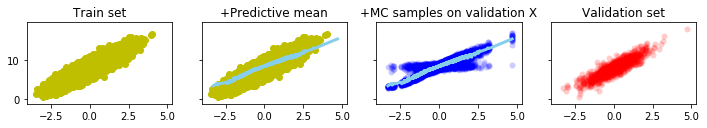

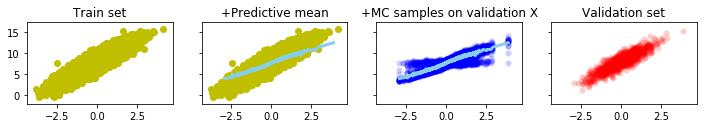

10000 2 - 1.13305354066 0.034341862824 [ 0.07651217  0.14340051  0.13155602  0.11183731  0.17202263]  -  1.2237768431 0.54942715355


In [6]:
results = []
# get results for multiple N
for N, nb_epoch in zip(Ns, nb_epochs):
    # repeat exp multiple times
    rep_results = []
    print(nb_epoch)
    for i in range(nb_reps):
        X, Y = gen_data(N + nb_val_size)
        X_train, Y_train = X[:N], Y[:N]
        X_val, Y_val = X[N:], Y[N:]
        sess, model_pred, ELBO = fit_model(nb_epoch, X_train, Y_train)
        MC_samples = [model_pred(X_val) for _ in range(K_test)]
        MC_samples = np.squeeze(np.array(MC_samples))
        pppp, rmse = test(Y_val, MC_samples)  # per point predictive probability
        means = MC_samples[:, :, :D]  # K x N
        epistemic_uncertainty = np.var(means, 0).mean(0)
        logvar = np.mean(MC_samples[:, :, D:], 0)
        aleatoric_uncertainty = np.exp(logvar).mean(0)
        ps = np.array([sess.run(layer_p) for layer_p in tf.get_collection('LAYER_P')])
        plot(X_train, Y_train, X_val, Y_val, means)
        
        rep_results += [(rmse, ps, aleatoric_uncertainty, epistemic_uncertainty)]
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[1] for r in rep_results], 0)
    aleatoric_uncertainty = np.mean([r[2] for r in rep_results])
    epistemic_uncertainty = np.mean([r[3] for r in rep_results])
    print(N, nb_epoch, '-', test_mean, test_std_err, ps, ' - ', aleatoric_uncertainty**0.5, epistemic_uncertainty**0.5)
    sys.stdout.flush()
    results += [rep_results]

In [7]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_aleatoric_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
best_epistemic_uncertainty = np.array([[r[3] for r in result] for result in results]).T.squeeze()
print(best_tests.mean(0))
print(best_ps.mean(1))

[ 1.60423202  1.19316615  1.11783758  1.10326831  1.16889844  1.13305354]
[[ 0.07415819  0.40364766  0.40347826  0.40335548  0.40377486]
 [ 0.06994522  0.36166361  0.36148462  0.36145067  0.36191145]
 [ 0.07725683  0.3153241   0.31516561  0.31510171  0.31565487]
 [ 0.07840168  0.23576896  0.23567824  0.2355396   0.23609598]
 [ 0.07366523  0.23019637  0.22964412  0.22558789  0.2344135 ]
 [ 0.07651217  0.14340051  0.13155602  0.11183731  0.17202263]]


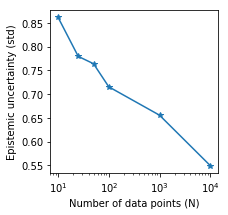

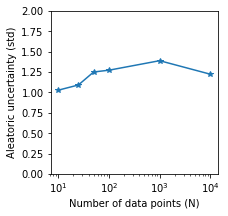

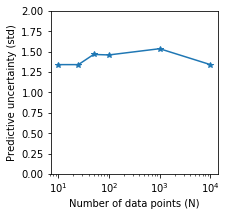

In [8]:
import pylab
%matplotlib inline

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
pylab.savefig('epistemic.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_aleatoric_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Aleatoric uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('aleatoric.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(Ns, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('predictive.pdf', bbox_inches='tight')
pylab.show()

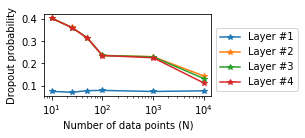

In [9]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(Ns, p, '-*', label='Layer #' + str(i+1))
#     pylab.fill_between(Ns, p + p_std, p - p_std, alpha=0.25)
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
pylab.savefig('dropout_prob.pdf', bbox_inches='tight')
pylab.show()